In [1]:
import numpy as np
import xarray as xr
from jetstream_hugo.definitions import DATERANGEPL_SUMMER, DATERANGEPL_EXT_6H_SUMMER, get_region, labels_to_mask, load_pickle
from jetstream_hugo.plots import *
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, cut_tree, dendrogram
import colormaps

try:
    %load_ext autorelaod
    %autoreload 2
except ModuleNotFoundError:
    pass

In [2]:
da = xr.open_dataarray('../data/ERA5/t/daily/dayofyear_doywin15/results/1/da.nc')
da = da.interp(time=DATERANGEPL_SUMMER, kwargs=dict(fill_value='extrapolate'))
mask = xr.open_dataarray('../data/ERA5/land_sea.nc').squeeze().rename(longitude='lon', latitude='lat').reset_coords('time', drop=True).astype(bool)
lon, lat = da.lon.values, da.lat.values
mask = mask.sel(lon=lon, lat=lat)

In [3]:
hot_days = da > da.quantile(0.75, dim='time')
stack_dims = {'lat_lon': ('lat', 'lon')}
hot_days_flat = hot_days.stack(stack_dims)
mask_flat = mask.stack(stack_dims)
hot_days_flat = hot_days_flat.values[:, mask_flat.values]

In [4]:
try:
    distances = np.load('distances.npy')
except FileNotFoundError:
    print('Computing distances')
    distances = pairwise_distances(hot_days_flat.T, metric='jaccard', n_jobs=-1)
    np.save('distances.npy', distances)
Z = linkage(squareform(distances), method='average')
tree = cut_tree(Z, height=np.linspace(0.01,1,100).tolist())

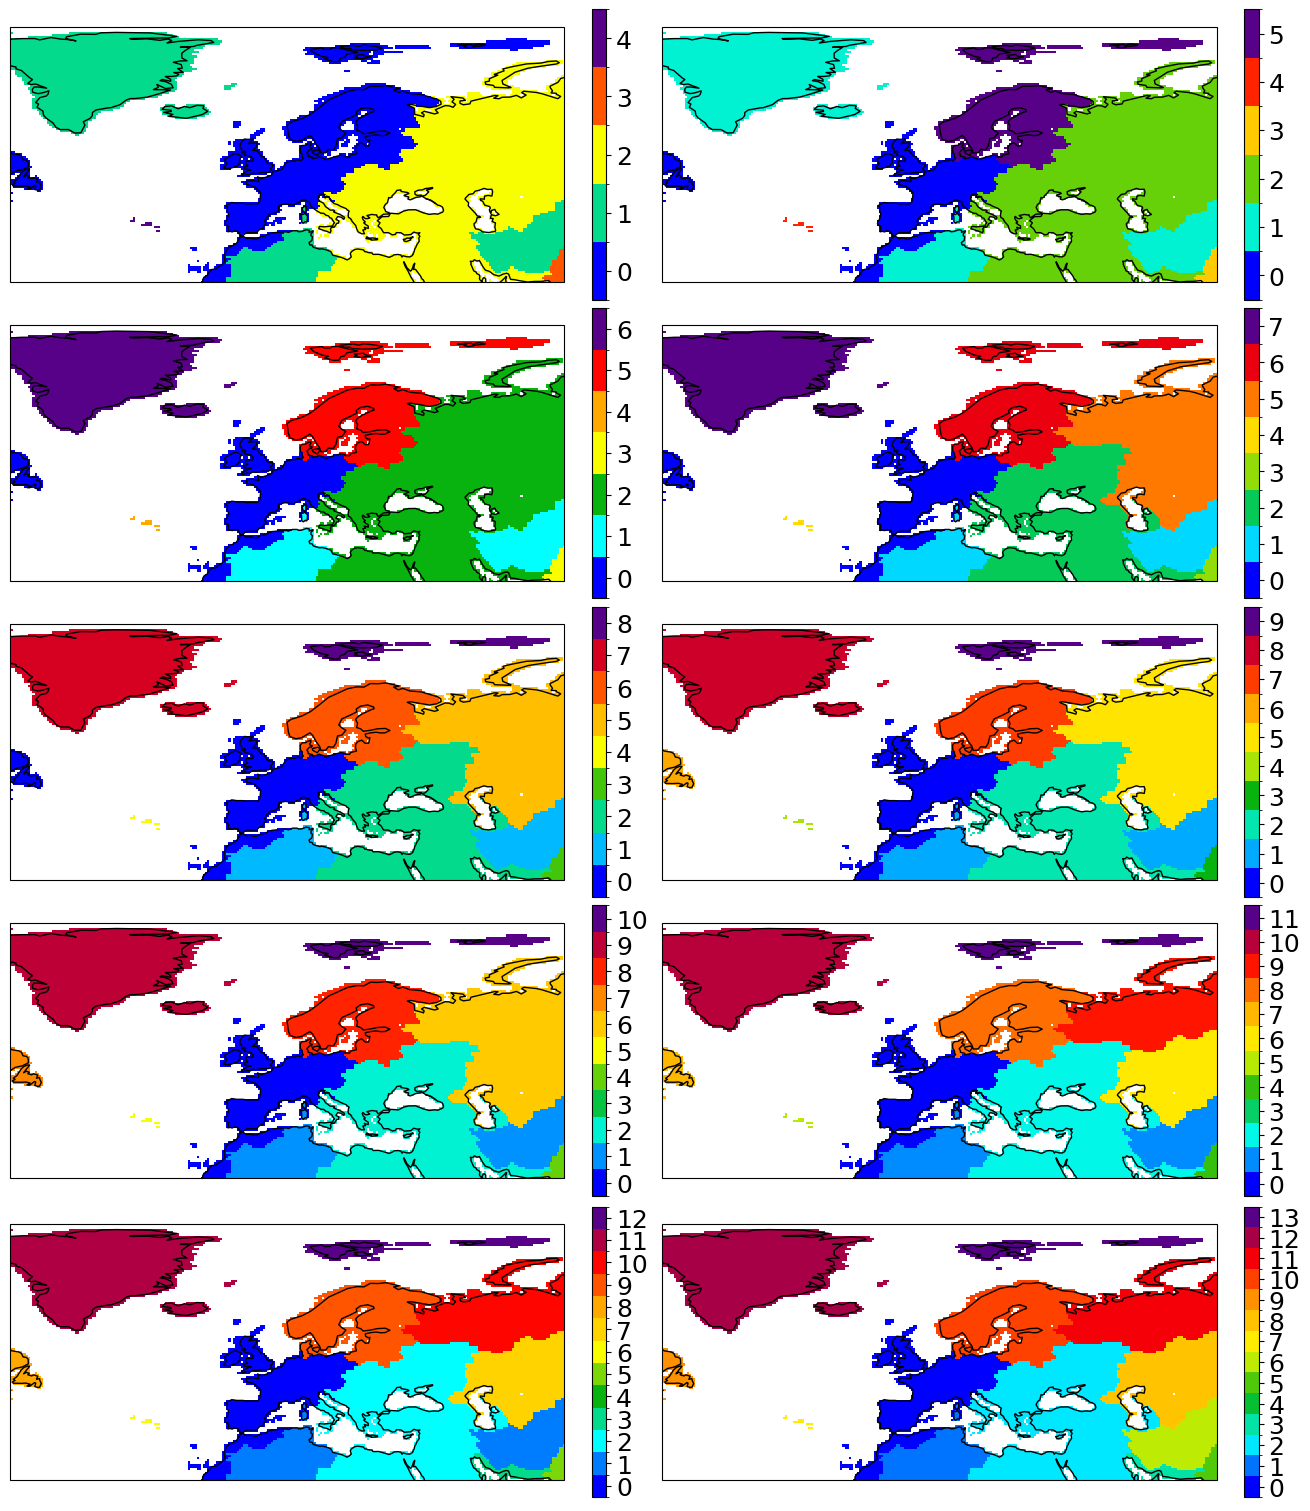

In [5]:
# np.linspace(0.01,1,100).tolist()
clu = Clusterplot(5, 2, get_region(mask))
cmap = colormaps.BlAqGrYeOrReVi200
for i, n_clu in enumerate(range(5, 15)):
    clusters = cut_tree(Z, n_clusters=n_clu)[:, 0]
    clusters_da = np.zeros(mask_flat.shape, dtype=float)
    clusters_da[:] = np.nan
    clusters_da = mask_flat.copy(data=clusters_da)
    clusters_da[mask_flat] = clusters
    unique_clusters = np.unique(clusters)
    norm = BoundaryNorm(np.concatenate([[-1], unique_clusters]) + 0.5, cmap.N)
    every = n_clu // 20 + 1
    clusters_da.unstack().plot(
        ax=clu.axes[i],
        cmap=cmap,
        norm=norm,
        add_colorbar=True,
        cbar_kwargs={"ticks": np.arange(0, n_clu, every)},
        add_labels=False,
    )

In [63]:
from jetstream_hugo.jet_finding import *
all_jets = load_pickle(f'{DATADIR}/ERA5/s/6H/results/1/all_jets.pkl')
all_props = compute_all_jet_props(all_jets, processes=14)
props_as_ds_uncat = props_to_ds(all_props, time=DATERANGEPL_EXT_6H_SUMMER)
props_as_ds = categorize_ds_jets(props_as_ds_uncat)
props_as_ds = props_as_ds.sel(time=np.isin(props_as_ds.time.dt.year, np.unique(da.time.dt.year.values)))
props_as_ds = props_as_ds.interp(time=da.time.values, kwargs=dict(fill_value='extrapolate'))

100%|██████████| 30544/30544 [00:13<00:00, 2269.90it/s]


In [64]:
n_clu = 12
clusters = cut_tree(Z, n_clusters=n_clu)[:, 0]
clusters_da = np.zeros(mask_flat.shape, dtype=float)
clusters_da[:] = np.nan
clusters_da = mask_flat.copy(data=clusters_da)
clusters_da[mask_flat] = clusters
central_europe = clusters_da.where(clusters_da==8).unstack()
da_cee = da.where(central_europe).mean(dim=['lon', 'lat'])
da_cee = da_cee.expand_dims(axis=1, **dict(timescale=timescales)).copy()
props_as_ds_ = props_as_ds.expand_dims(axis=2, **dict(timescale=timescales)).copy()
for i, n_days in tqdm(enumerate(timescales[1:])):
    da_cee[:, i + 1] = da_cee[:, 0].rolling(time=n_days, min_periods=1, center=True).mean()
    for varname in props_as_ds_.data_vars:
        props_as_ds_[varname][:, :, i + 1] = props_as_ds_[varname][:, :, 0].rolling(time=n_days, min_periods=1, center=True).mean()

7it [00:00, 240.07it/s]


In [65]:
props_as_ds_.loc[:, :, 0]

TypeError: can only lookup dictionaries from Dataset.loc